In [3]:
import numpy as np
import math
import random

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import linear_model, datasets


# Plotter:---------------------------------------------------------
import matplotlib.pyplot as plt

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,5
#--------------(plotter)-------------------------------------------

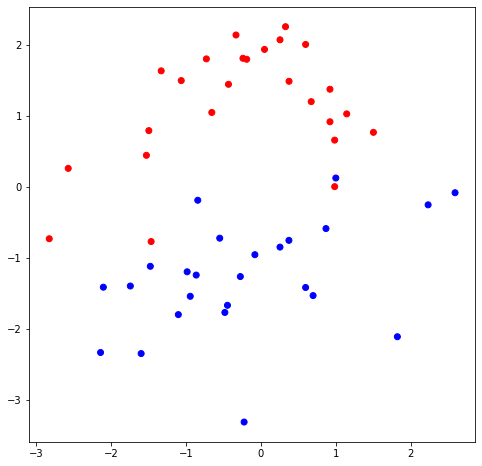

In [23]:


# Data set example:-------------------------------------------------------------------------
# n_samples int, default=100 The number of samples.
# n_features int, default=20 The total number of features. These comprise n_informative informative features, n_redundant redundant features, n_repeated duplicated features and n_features-n_informative-n_redundant-n_repeated useless features drawn at random.
# n_informative int, default=2 The number of informative features. Each class is composed of a number of gaussian clusters each located around the vertices of a hypercube in a subspace of dimension n_informative. For each cluster, informative features are drawn independently from N(0, 1) and then randomly linearly combined within each cluster in order to add covariance. The clusters are then placed on the vertices of the hypercube.
# n_redundant int, default=2 The number of redundant features. These features are generated as random linear combinations of the informative features.
# n_repeated int, default=0 The number of duplicated features, drawn randomly from the informative and the redundant features.
# n_classes int, default=2 The number of classes (or labels) of the classification problem.
# n_clusters_per_class int, default=2 The number of clusters per class.
# weights array-like of shape (n_classes,) or (n_classes - 1,), default=None The proportions of samples assigned to each class. If None, then classes are balanced. Note that if len(weights) == n_classes - 1, then the last class weight is automatically inferred. More than n_samples samples may be returned if the sum of weights exceeds 1. Note that the actual class proportions will not exactly match weights when flip_y isn’t 0.
# flip_y float, default=0.01 The fraction of samples whose class is assigned randomly. Larger values introduce noise in the labels and make the classification task harder. Note that the default setting flip_y > 0 might lead to less than n_classes in y in some cases.
# class_sep float, default=1.0 The factor multiplying the hypercube size. Larger values spread out the clusters/classes and make the classification task easier.
# hypercube bool, default=True If True, the clusters are put on the vertices of a hypercube. If False, the clusters are put on the vertices of a random polytope.
# shift float, ndarray of shape (n_features,) or None, default=0.0 Shift features by the specified value. If None, then features are shifted by a random value drawn in [-class_sep, class_sep].
# scale float, ndarray of shape (n_features,) or None, default=1.0 Multiply features by the specified value. If None, then features are scaled by a random value drawn in [1, 100]. Note that scaling happens after shifting.
# shuffle bool, default=True Shuffle the samples and the features.
# random_state int, RandomState instance or None, default=None Determines random number generation for dataset creation. Pass an int for reproducible output across multiple function calls. See Glossary.

# сгеренируем данные с помощью sklearn.datasets
X, Y = datasets.make_classification(
    n_samples=50,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    random_state=1
)

colors = ListedColormap(['blue', 'red'])

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=colors);

#print (X[:, 0])
#print (X[:, 1])
#print (X)
#print (Y)

Запрограммируем логистическу регрессию

In [40]:
def max_min (X) : 
    max = np.amax(X)
    min = np.amin(X)
    return max,min

# The basic sigmoid function 
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1*x))

# Function is used to transform mean and standard diviation of the normal distribution
# to the A,B boundaries of the uniformed distribution
def calculate_uniform_a_b ( mean=0, std_deviation=1 ) :
    c = 3 ** 0.5
    a = mean - c*std_deviation
    b = mean + c*std_deviation
    return a,b

#
# Function makes the random vector with controlled standard deviation and average mean.
# It's assumed that random vector can be made by uniform or normal distribution laws
# mean - the average mean value
# std_deviation - the standard deviation of the each generated vector
# coordinate_number - the size or vector dimension value. e.g. 2-D, 3-D, ..., coordinate_number-D
# is_normal - the flag of selected generator: True means normal False means uniform
#
def make_random_vector (mean=0, std_deviation=1, coordinate_number = 2, is_normal=True) :
    if (is_normal):
        return np.random.normal(mean,std_deviation,size=(coordinate_number))
    else :
        a,b = calculate_uniform_a_b(mean,std_deviation)
        return np.random.uniform(a,b,size=(coordinate_number))

#
# The class of the linear function. Weights variables mean the linear coefficients
# The threshold means the 'free coefficient' which is added to the weighted result
# The method 'calculate' is the main method of LinearFunction object
#
class LinearFunction :
    def __init__ (self,weights,threshold) :
        self.weights = weights
        self.threshold = threshold
    
    #
    # Linear calculating of the input X by the weights and threshold
    #
    def calculate (self,x_matrix):
        return np.dot(x_matrix,self.weights)+self.threshold
    
    #
    # The method sets all coefficients by random value.
    # It's used as an initial point of adapting
    #
    def reset_by_random ( self, weight_number, mean, std_deviation ):
        self.weights = make_random_vector( 
            mean=mean,
            std_deviation = std_deviation,
            coordinate_number = weight_number,
            is_normal=True
        )
        a,b = calculate_uniform_a_b(mean=mean,std_deviation=std_deviation)
        self.threshold = random.uniform(a,b)
        return self;
    
    #
    # The method corrects the internal weights and thresholds
    # By correction vectors and step coefficient
    # delta_w is the correction vector for weights
    # step is the correction cefficient.
    # delta_t is the correction value for the threshold
    #
    def correct(self,delta_w,step,delta_t):
        self.weights+=delta_w*step
        self.threshold+=delta_t*step
        return self;


class LogLossRegression :
    
    def __init__ (self):
        self.linear_function = None;
        self.iteration_cnt_max = 10000000;
        self.initialize(np.array([[0,1]]))
    
    def fit (self, x_matrix, y_vector, e_min, step, is_random_selected=False, error_list=[] ):
        self.initialize(x_matrix);
        self.adapt(X=x_matrix,Y=y_vector,min_delta_error=e_min,step=step,is_random_selected,error_list);
        return self;
        
    def predict (self,x_matrix):
        return sigmoid(self.linear_function.calculate(x_matrix));
    
    def predict_possibility (self,x):
        y = self.predict(x_matrix=x);
        y=np.where(y<0.5,y,1);
        y=np.where(y>=0.5,y,0);
        return y;
        
    def initialize (self,x_matrix):
        max,min = max_min(x_matrix);
        self.linear_function = LinearFunction(None,None).reset_by_random(weight_number=x_matrix.shape[1],mean=0.0,std_deviation=(max-min)/100);
        
        return self;
    
    def predict_delta(self,x,y):
        return self.predict(x)-y;
    
    def calculate_log_loss_error(self,x_sample,y_value):
        predict_value = self.predict(x_sample);
        reverse_y = 1 - y_value;
        reverse_predict = 1 - predict_value;
        error = y_value*self.ln(predict_value)+reverse_y*self.ln(reverse_predict)
        error *= -1;
        return error;
    
    def ln (self,x):
        x_cut = np.where(x>0,x,0.000000000001);
        return np.log(x_cut);
    
    def adapt (self, X, Y, min_delta=0.1, step=0.00001, is_random_selected=False, error_list=[]):
        
        iteration_cnt = 0;
        er1=0.0
        er2=0.0
        max_distance = abs(np.amax(Y)- np.amin(Y))/4
        
        while True:
            dE_dW_vector,dE_dT_scalar,error_scalar = self.calculate_de( X, Y, is_random_selected );
            self.linear_function.correct( delta_w=dE_dW_vector, step=-1*step, delta_t=dE_dT_scalar )

            if error_list!=None : error_list.append(error_scalar);
                        
            er1 = er2;
            er2 = np.linalg.norm(dE_dW_vector*step, ord=2);
            eps = abs(er1-er2)/max(er1,er2);
            iteration_cnt += 1
            
            if iteration_cnt % 1000==0:
                self.log(iteration_cnt,error_scalar,dE_dW_vector,er1,er2,eps,max_distance)
            if iteration_cnt>=self.iteration_cnt_max or (eps<min_delta and error_scalar<max_distance) or eps==0.0:
                self.log(iteration_cnt,error_scalar,dE_dW_vector,er1,er2,eps,max_distance)
                break;
                
        return self;
    
    def calculate_de (self,X,Y,is_random_selected) :
        
        index_range=None;
        
        if (is_random_selected):
            rand_num = random.randint(0,X.shape[0]-1)
            index_range = range(rand_num,rand_num+1);
        else :
            index_range = range(0,X.shape[0]);
            
        dE_dW_vector = np.zeros(X.shape[1])
        dE_dT_scalar = 0.0
        error_scalar = 0.0
            
        for k in index_range:
            error_scalar += self.calculate_log_loss_error(x_sample=X[k],y_value=Y[k])
            dE_dT_scalar += self.predict_delta(X[k],Y[k])
            dE_dW_vector += X[k]*dE_dT_scalar
            
        dE_dW_vector = dE_dW_vector/len(index_range)
        dE_dT_scalar = dE_dT_scalar/len(index_range)
        error_scalar = error_scalar/len(index_range)
            
        return dE_dW_vector,dE_dT_scalar,error_scalar;
        
    def log (self,iteration_cnt,error_scalar,dE_dW_vector,er1,er2,eps,max_distance):
        print ("{}_e={}_v={}__dv1={}___dv2={}__eps={}_d={}"
               .format(iteration_cnt,error_scalar,dE_dW_vector,er1,er2,eps,max_distance))


Запустим LogLos- регрессию для параметров минимальная дельта по коррекции в процентах 0.01% шаг обучения 0.002

In [41]:
error_list_1 = []
loglossRegression = LogLossRegression().fit(X,Y,0.0001,0.002,False,error_list_1)


1000_e=0.5239049102425023_v=[-0.01144768 -0.13401206]__dv1=0.0002691433601738038___dv2=0.0002690002356449032__eps=0.0005317780412944084_d=0.2
2000_e=0.44307754045252745_v=[-0.01114074 -0.08148756]__dv1=0.00016456697303591123___dv2=0.00016449119983797983__eps=0.00046043988373573014_d=0.2
3000_e=0.4031127176900414_v=[-0.0110195  -0.05169027]__dv1=0.0001057489023750345___dv2=0.00010570360778497705__eps=0.00042832208221706147_d=0.2
4000_e=0.38180301003876066_v=[-0.01051361 -0.0330664 ]__dv1=6.942400411661301e-05___dv2=6.939517976777718e-05__eps=0.00041519283139309943_d=0.2
5000_e=0.37029918310323323_v=[-0.00982254 -0.02077817]__dv1=4.5984622754517895e-05___dv2=4.596583552445653e-05__eps=0.00040855461969659606_d=0.2
6000_e=0.36444506030602275_v=[-0.00903983 -0.01242317]__dv1=3.074018307015745e-05___dv2=3.072808153415691e-05__eps=0.0003936715657457644_d=0.2
7000_e=0.36203620579663087_v=[-0.00820246 -0.00666671]__dv1=2.1147363373574983e-05___dv2=2.114003530292441e-05__eps=0.000346524080620385

57000_e=0.3905800103627338_v=[ 1.54848268e-07 -5.36524077e-07]__dv1=1.1170759411529152e-09___dv2=1.1168456847206032e-09__eps=0.00020612424261352743_d=0.2
58000_e=0.39057973518616607_v=[ 1.15041100e-07 -4.37683654e-07]__dv1=9.052937907350831e-10___dv2=9.050998524956861e-10__eps=0.00021422685252211446_d=0.2
59000_e=0.3905795144463684_v=[ 8.42055183e-08 -3.53940186e-07]__dv1=7.277995958271847e-10___dv2=7.276378886405248e-10__eps=0.00022218641998020608_d=0.2
60000_e=0.39057933886926277_v=[ 6.05512997e-08 -2.83785361e-07]__dv1=5.80480337263344e-10___dv2=5.803467609345082e-10__eps=0.0002301134427145174_d=0.2
61000_e=0.39057920040392635_v=[ 4.25968927e-08 -2.25614980e-07]__dv1=4.593113486916079e-10___dv2=4.592019788326857e-10__eps=0.00023811704029026059_d=0.2
62000_e=0.39057909216016895_v=[ 2.91276854e-08 -1.77839402e-07]__dv1=3.605067484066309e-10___dv2=3.6041795238252485e-10__eps=0.00024630890960715656_d=0.2
63000_e=0.3905790083138859_v=[ 1.91567699e-08 -1.38953341e-07]__dv1=2.8060679513036

111000_e=0.3905787793839316_v=[7.92246707e-13 4.13068538e-14]__dv1=1.5870574426430888e-15___dv2=1.5866456450874855e-15__eps=0.0002594723697697162_d=0.2
112000_e=0.39057877938368635_v=[ 6.78749161e-13 -1.88247678e-13]__dv1=1.4085848326405423e-15___dv2=1.4087407317228605e-15__eps=0.00011066556024654798_d=0.2
113000_e=0.39057877938338187_v=[ 5.73754927e-13 -3.25181199e-13]__dv1=1.3191771857232588e-15___dv2=1.3189958737188892e-15__eps=0.0001374432535158096_d=0.2
114000_e=0.390578779383055_v=[ 4.80121712e-13 -3.97251736e-13]__dv1=1.246368179158493e-15___dv2=1.2463158517889133e-15__eps=4.198387800222374e-05_d=0.2
115000_e=0.3905787793827276_v=[ 3.97583053e-13 -4.23215135e-13]__dv1=1.1613742524539183e-15___dv2=1.1613497915150538e-15__eps=2.1062064027019393e-05_d=0.2
116000_e=0.3905787793824112_v=[ 3.25512418e-13 -4.16210000e-13]__dv1=1.0569032071420355e-15___dv2=1.0567669526628011e-15__eps=0.00012891859757226722_d=0.2
117000_e=0.3905787793821389_v=[ 2.65109818e-13 -4.01759215e-13]__dv1=9.6291

Сделаем предсказание на выборке, по которой происходило обучение для визуальной оценки качества полученной модели

array([0.19407669, 0.6540333 , 0.73626398, 0.43518836, 0.27470281,
       0.73338901, 0.87421533, 0.81079427, 0.25230143, 0.5879408 ,
       0.69809222, 0.84421369, 0.79114083, 0.29621369, 0.07111284,
       0.24192584, 0.19507139, 0.27864333, 0.25086189, 0.39734149,
       0.20918377, 0.74199356, 0.60406237, 0.58009194, 0.80007325,
       0.35181029, 0.29208928, 0.51852544, 0.85523074, 0.33567608,
       0.17913694, 0.0949856 , 0.10553167, 0.76676503, 0.85883805,
       0.23925155, 0.16959238, 0.79334894, 0.6028525 , 0.762611  ,
       0.20620978, 0.45795945, 0.75404381, 0.24228228, 0.83488458,
       0.37301469, 0.74019309, 0.42125162, 0.81062134, 0.68036577])

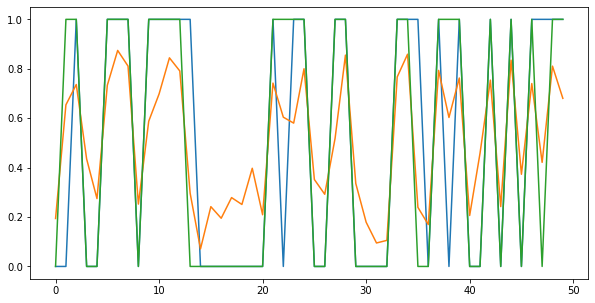

In [46]:
Y_predict = loglossRegression.predict(X);
Y_predict_possibility = loglossRegression.predict_possibility(X);

plt.plot(Y)
plt.plot(Y_predict)
plt.plot(Y_predict_possibility)
Y_predict

<b>Задания: Логистическая регрессия. Log Loss</b><br>
1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log (как вариант - использовать np.clip или np.where).<br>
2. На данных из урока изучите влияние гиперпараметров на ошибку алгоритма.
3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса "1". На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model.<br>
4. Создайте функцию calc_pred, возвращающую предсказанные классы (0 или 1). На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией eval_LR_model, а также порог вероятности.<br>

<b>Ответы по заданиям:</b>
1. Разработана функция:<br>
 def ln (self,x):
        x_cut = np.where(x>0,x,0.000000000001);
        return np.log(x_cut);
2. Параметры: минимальная коррекция = <b>0.01%</b> и шаг обучения <b>0.002</b> дают приемлимый результат<br>
3. Сделана функция <b>predict</b> у класса <b>LogLossRegression</b>, которая отвечает заявленным требованиям<br>
4. Сделана функция <b>predict_possibility</b> у класса <b>LogLossRegression</b>, которая отвечает заявленным требованиям<br>